# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [1]:
from pathlib import Path

# Parameters tag for Papermill
USE_UCIMLREPO = False
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'
STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic' 

ARTIFACTS_PREFIX = 'arima_pm25'

In [2]:
# Parameters
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
STATION = "Aotizhongxin"
VALUE_COL = "PM2.5"
CUTOFF = "2017-01-01"
P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = "aic"
ARTIFACTS_PREFIX = "sarima_pm25_analysis"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.classification_library import load_beijing_air_quality, clean_air_quality_df
from src.timeseries_library import (
    StationSeriesConfig, make_hourly_station_series, describe_time_series,
    train_test_split_series, grid_search_arima_order, fit_arima_and_forecast
)

try:
    PROJECT_ROOT
except NameError:
    from pathlib import Path
    PROJECT_ROOT = Path().resolve()

# Đảm bảo đường dẫn tuyệt đối cho Raw Data
abs_zip_path = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())
print("RAW_ZIP_PATH =", abs_zip_path)

RAW_ZIP_PATH = /hdd3/namdh/datamining/air_quality_timeseries/data/raw/PRSA2017_Data_20130301-20170228.zip


In [4]:
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=abs_zip_path)
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)

diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

/hdd3/namdh/datamining/air_quality_timeseries/src/timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105408,
  "std": 81.95640129983182,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673323,
  "autocorr_lag_168": 0.016796754924567902
}


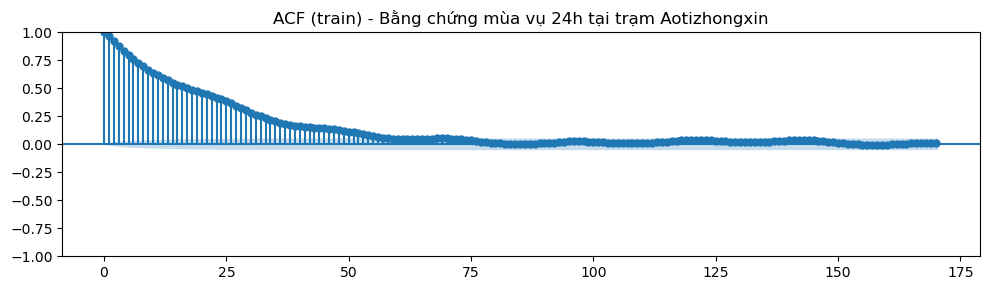

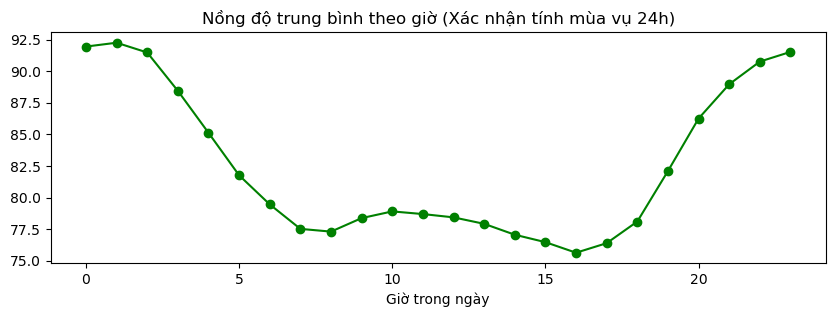

In [5]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
x = train.dropna()

# Biểu đồ ACF với lag 170 để thấy chu kỳ tuần (168h) và ngày (24h)
plt.figure(figsize=(10,3))
plot_acf(x, lags=170, ax=plt.gca()) 
plt.title(f'ACF (train) - Bằng chứng mùa vụ 24h tại trạm {STATION}')
plt.tight_layout()
plt.show()

# Kiểm tra trung bình nồng độ theo giờ trong ngày
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
plt.figure(figsize=(10,3))
plt.plot(hod.index, hod.values, marker='o', color='green')
plt.title('Nồng độ trung bình theo giờ (Xác nhận tính mùa vụ 24h)')
plt.xlabel('Giờ trong ngày')
plt.show()

In [6]:
# Chạy Grid Search để tìm p, d, q tốt nhất cho phần phi mùa vụ [cite: 95]
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best non-seasonal order:', best_order, '| score:', gs['best_score'])

Best non-seasonal order: (1, 0, 3) | score: 294792.7063482919


In [7]:
# Cấu hình SARIMA (p,d,q) x (P,D,Q,s)
# Sử dụng s=24 cho chu kỳ ngày theo bằng chứng ở Bước 1 
P, D, Q, seasonal_s = 1, 1, 0, 24 

print(f"Đang huấn luyện SARIMA{best_order}x({P},{D},{Q},{seasonal_s})...")
model_sarima = SARIMAX(
    train, 
    order=best_order, 
    seasonal_order=(P, D, Q, seasonal_s),
    enforce_stationarity=False, 
    enforce_invertibility=False
)

results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())

Đang huấn luyện SARIMA(1, 0, 3)x(1,1,0,24)...


                                      SARIMAX Results                                      
Dep. Variable:                               PM2.5   No. Observations:                33648
Model:             SARIMAX(1, 0, 3)x(1, 1, [], 24)   Log Likelihood             -153735.762
Date:                             Wed, 31 Dec 2025   AIC                         307483.524
Time:                                     18:36:49   BIC                         307534.058
Sample:                                 03-01-2013   HQIC                        307499.652
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9424      0.001    634.448      0.000       0.939       0.945
ma.L1          0.2579      

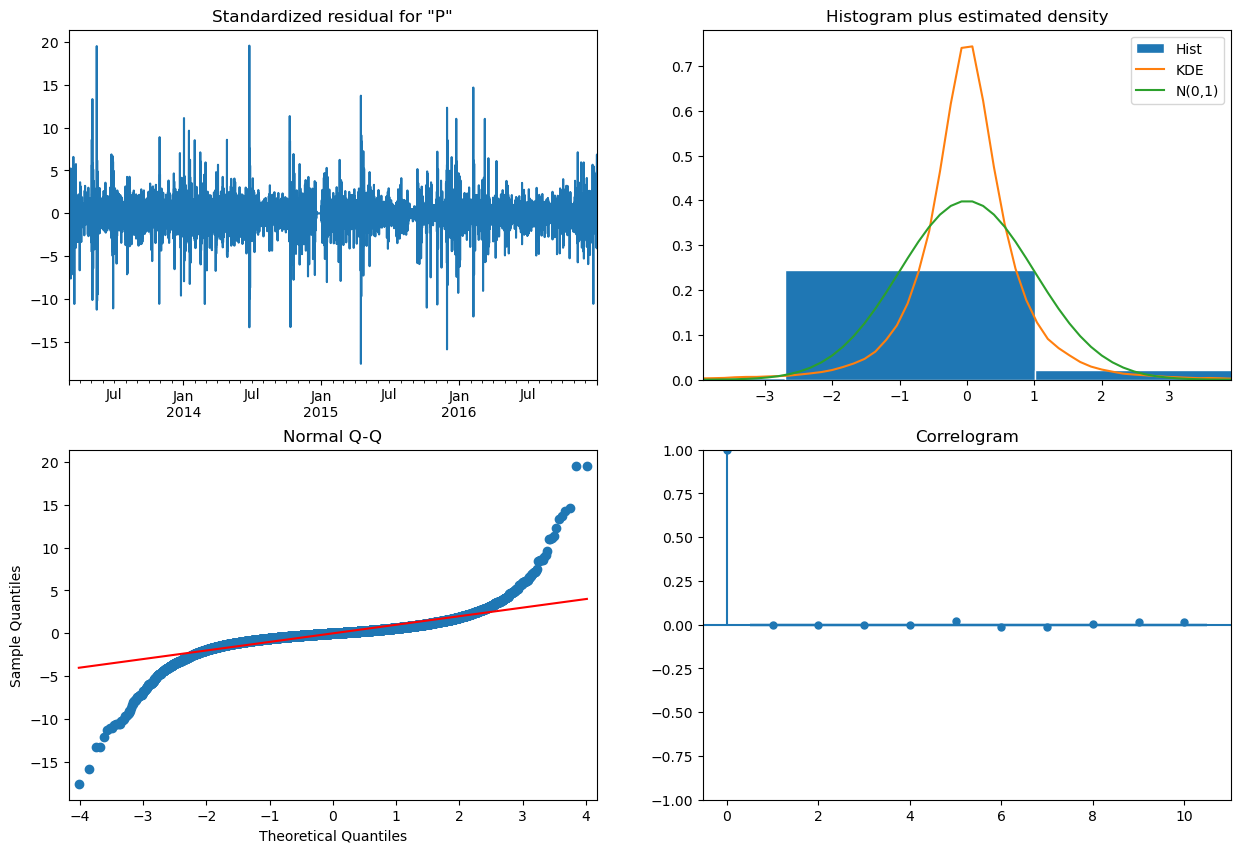

In [8]:
# Chẩn đoán phần dư để đảm bảo mô hình đã học hết quy luật chu kỳ [cite: 223]
results_sarima.plot_diagnostics(figsize=(15, 10))
plt.show()

--- KẾT QUẢ ĐÁNH GIÁ SARIMA ---
RMSE: 297.74
MAE: 271.04


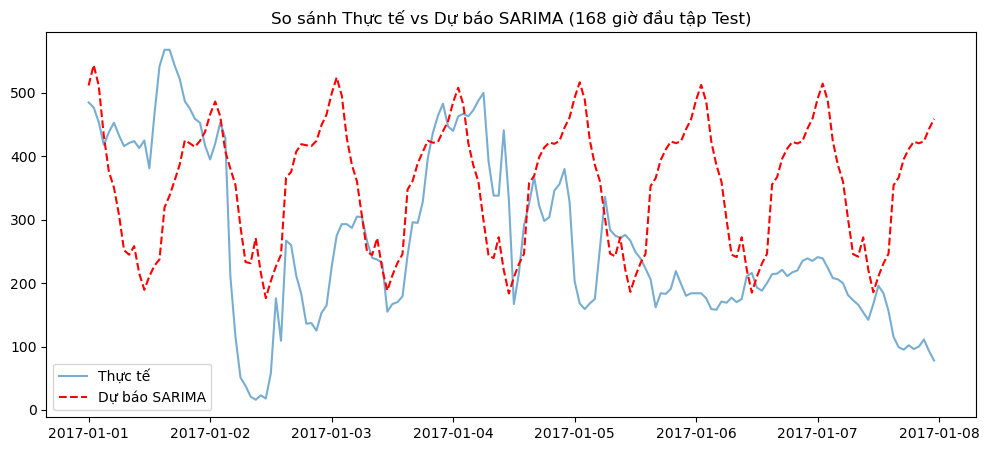

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dự báo trên tập test [cite: 198]
forecast_obj = results_sarima.get_forecast(steps=len(test))
yhat_sarima = forecast_obj.predicted_mean
ci_sarima = forecast_obj.conf_int()

# Tính toán các thước đo sai số [cite: 105-108]
rmse_sarima = np.sqrt(np.mean((test.values - yhat_sarima.values)**2))
mae_sarima = np.mean(np.abs(test.values - yhat_sarima.values))

print(f"--- KẾT QUẢ ĐÁNH GIÁ SARIMA ---")
print(f"RMSE: {rmse_sarima:.2f}")
print(f"MAE: {mae_sarima:.2f}")

# Vẽ đồ thị so sánh (1 tuần đầu tiên của tập test)
plot_n = 24 * 7
plt.figure(figsize=(12, 5))
plt.plot(test.index[:plot_n], test.values[:plot_n], label='Thực tế', alpha=0.6)
plt.plot(test.index[:plot_n], yhat_sarima.values[:plot_n], label='Dự báo SARIMA', color='red', linestyle='--')
plt.title(f'So sánh Thực tế vs Dự báo SARIMA (168 giờ đầu tập Test)')
plt.legend()
plt.show()

In [10]:
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

# Lưu kết quả dự báo ra CSV
pred_df = pd.DataFrame({
    'datetime': test.index,
    'y_true': test.values,
    'y_pred_sarima': yhat_sarima.values
})
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_sarima_predictions.csv', index=False)

# Lưu tóm tắt kết quả
summary = {
    'station': STATION,
    'best_order_non_seasonal': best_order,
    'seasonal_order': (P, D, Q, seasonal_s),
    'sarima_rmse': rmse_sarima,
    'sarima_mae': mae_sarima,
    'diagnostics': diag
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print('Đã lưu Artifacts tại:', out_dir)

Đã lưu Artifacts tại: /hdd3/namdh/datamining/air_quality_timeseries/data/processed
